# Urban data ecosystems in Covid-19 times and the roleof OpenStreetMap in providing public services:experiences and reflections from the Italian case
## analysis produced for the research

### analyzes taken into account 

#### intervention by the Italian community in the first outbreak cities
The cities in question are those of [Codogno](https://www.openstreetmap.org/#map=14/45.1667/9.6793)(Lodi) and [Vo'](https://www.openstreetmap.org/#map=16/45.3305/11.6422)(Padua)<br/>
The analysis focuses on building data collection<br/>
The period under consideration taken into consideration the weeks from from 23 February to 7 March

#### data entry regarding pharmacies in Italy 
the Italian community has undertaken to update and correct the data with the positions of pharmacies in Italy starting from the [open data dataset of the italian ministry of health](https://www.dati.salute.gov.it/dati/dettaglioDataset.jsp?menu=dati&idPag=5)

#### insertion of delivery service keys created during lock-down
during the lockdown period many commercial activities activated for the delivery service and, from here, the international community took action by [bringing this data](https://wiki.openstreetmap.org/wiki/COVID-19_-_How_to_Map#Keys_delivery.2C_takeaway.2C_drive-through_services) to OpenStreetMap


## libraries needed
the analysis relies on the API of the [OHSOME project](https://heigit.org/big-spatial-data-analytics-en/ohsome/)

In [2]:
import geopandas as gpd
import os
import pandas as pd
import matplotlib.pyplot as plt
import contextily as cx
import seaborn as sns
from ohsome import OhsomeClient
from shapely.geometry import Polygon
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style="ticks", palette="pastel")

/home/napo/.local/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.9.0-CAPI-1.16.2) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


## data setup
- time range of the analysis: weeks from from 23 February to 7 March, each months of 2020, each weeks of 2020
- borders of Codogno and Vo' (geojson created by the [shapefile](https://www.istat.it/storage/cartografia/confini_amministrativi/non_generalizzati/Limiti01012020.zip) of the [italian administrative boundaries](https://www.istat.it/it/archivio/222527) of ISTAT - Italian National Institute of Statistics) - license in cc-by
- borders of Italy (geojson created by the [shapefile](https://www.istat.it/storage/cartografia/confini_amministrativi/non_generalizzati/Limiti01012020.zip) of the [italian administrative boundaries](https://www.istat.it/it/archivio/222527) of ISTAT - Italian National Institute of Statistics) - license in cc-by



### time periods

In [3]:
time_weaks_2020 =  "{}/{}/P1W".format("2020-01-01", "2020-12-31")
time_months_2020 =  "{}/{}/P1W".format("2020-01-01", "2020-12-31")
time_february_march_2020 =  "{}/{}/P1D".format("2020-02-23", "2020-03-07")

### geodata (borders)

In [4]:
borders_codogno=gpd.read_file("data" + os.sep + "borders" + os.sep + "codogno.geojson")
borders_vo=gpd.read_file("data" + os.sep + "borders" + os.sep + "vo.geojson")
borders_italy = gpd.read_file("data" + os.sep + "borders" + os.sep + "italy.geojson")

#### show the borders on a map
*Codogno*

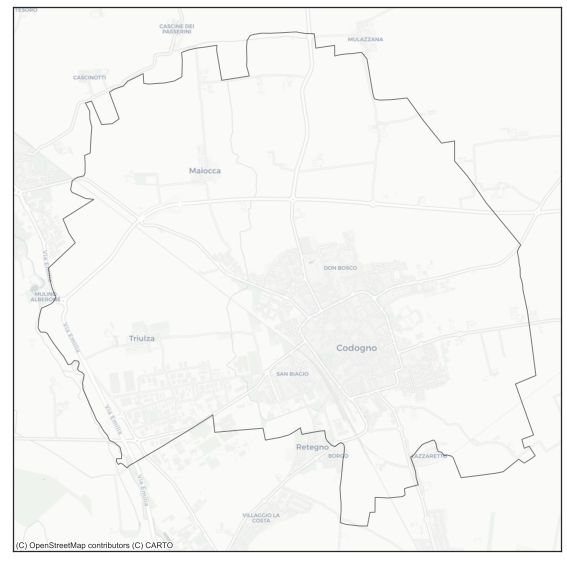

In [5]:
ax = borders_codogno.to_crs(epsg=3857).plot(figsize=(10, 10), facecolor="none",alpha=0.5, edgecolor='black')
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
cx.add_basemap(ax,source=cx.providers.CartoDB.Positron)

*Vo'*

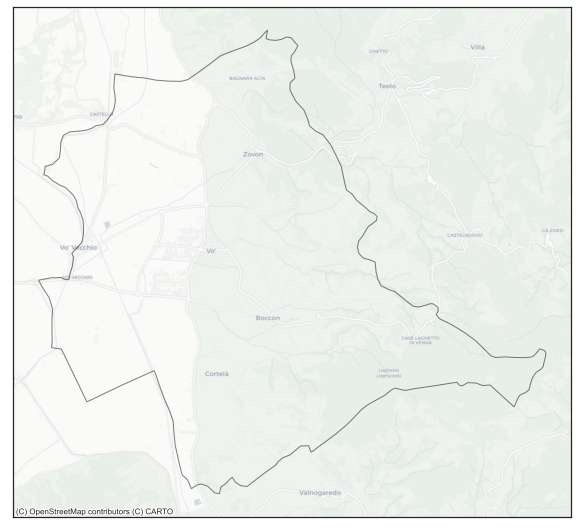

In [6]:
ax = borders_vo.to_crs(epsg=3857).plot(figsize=(10, 10), facecolor="none",alpha=0.5, edgecolor='black')
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
cx.add_basemap(ax,source=cx.providers.CartoDB.Positron)

*Italy*

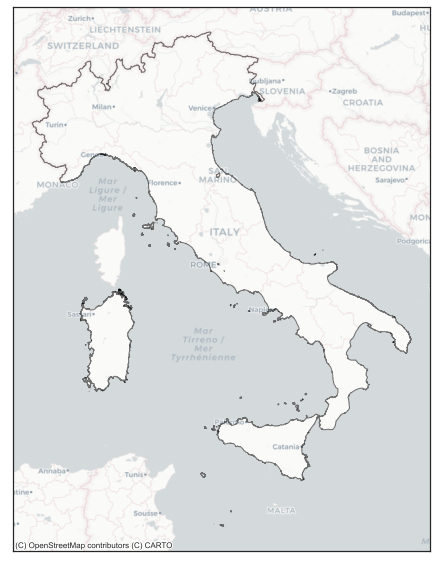

In [7]:
ax = borders_italy.to_crs(epsg=3857).plot(figsize=(10, 10), facecolor="none",alpha=0.5, edgecolor='black')
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
cx.add_basemap(ax,source=cx.providers.CartoDB.Positron)

## Data Extraction
the extraction is based on [OHSOME api](https://heigit.org/big-spatial-data-analytics-en/ohsome/)

In [8]:
client = OhsomeClient()

### intervention by the Italian community in the first outbreak cities

The two cities taken into consideration are Codogno and Vo ': the first Italian outbreaks where the government has begun the first interventions.

In the specific case it was decided to identify the contribution of the community in the creation of the buildings

In [9]:
tags = ["building=*"]

#### Buildings in Codogno

In [10]:
%%time
data = []
for tag in tags:
    response = client.elements.count.groupByBoundary.post(
        bpolys=borders_codogno.geometry.to_json(),
        time=time_february_march_2020,
        filter="{} and (type:relation or type:way) and geometry:polygon".format(tag))
    data.append(response.as_dataframe().rename(columns={"value":tag}))
buildings_codogno = pd.concat(data, axis=1)

CPU times: user 45.9 ms, sys: 0 ns, total: 45.9 ms
Wall time: 53.2 s


In [11]:
buildings_codogno.head(10)

building=*
boundary timestamp                            
0        2020-02-23 00:00:00+00:00       302.0
         2020-02-24 00:00:00+00:00       302.0
         2020-02-25 00:00:00+00:00      1152.0
         2020-02-26 00:00:00+00:00      1256.0
         2020-02-27 00:00:00+00:00      5790.0
         2020-02-28 00:00:00+00:00      5803.0
         2020-02-29 00:00:00+00:00      5846.0
         2020-03-01 00:00:00+00:00      5846.0
         2020-03-02 00:00:00+00:00      5846.0
         2020-03-03 00:00:00+00:00      5846.0

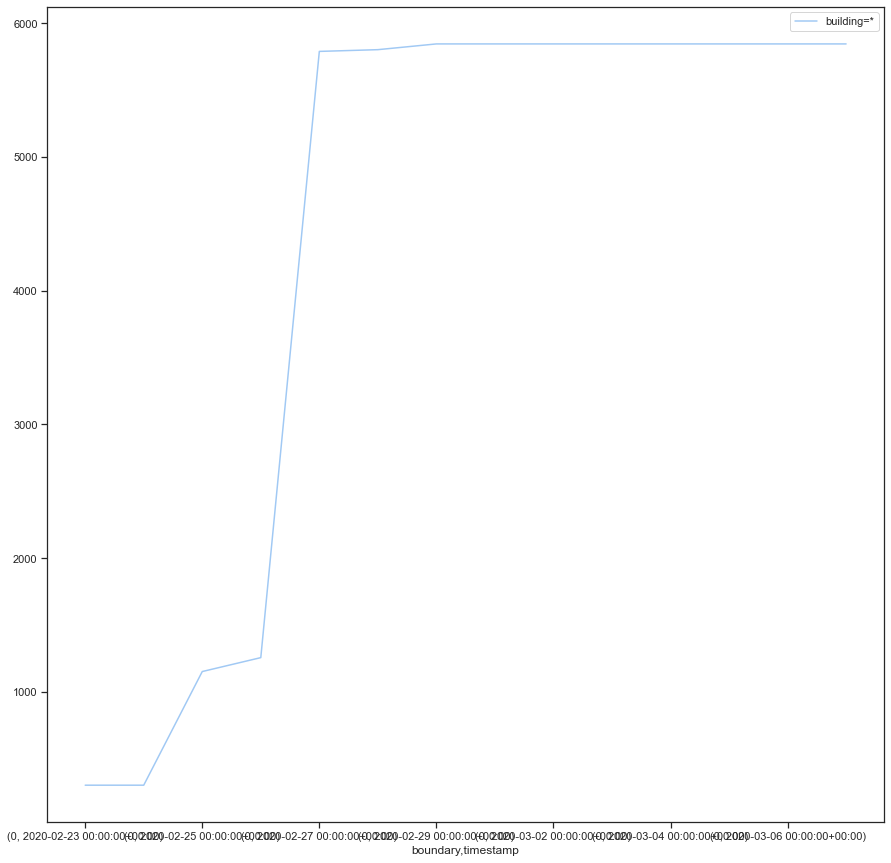

In [12]:
buildings_codogno.plot(figsize=(15,15))
plt.show()

In [13]:
print("The total number of buildings before Codogno became a hotbed (2020-02-15) city is " + str(int(buildings_codogno['building=*'].min())))
print("The total number of buildings after Codogno became a hotbed (2020-02-15) city is " + str(int(buildings_codogno['building=*'].max())))

The total number of buildings before Codogno became a hotbed (2020-02-15) city is 302
The total number of buildings after Codogno became a hotbed (2020-02-15) city is 5846


In [14]:
# organize the data to create the csv file
buildings_codogno.reset_index(inplace=True)
buildings_codogno.rename(columns={'building=*':'total_building'}, inplace=True)
del buildings_codogno['boundary']
buildings_codogno.total_building = buildings_codogno.total_building.astype(int)

In [15]:
# save file
buildings_codogno.to_csv("data" + os.sep + "buildings_codogno.csv", index=False)

#### Buildings in Vo'

In [ ]:
%%time
data = []
for tag in tags:
    response = client.elements.count.groupByBoundary.post(
        bpolys=borders_vo.geometry.to_json(),
        time=time_february_march_2020,
        filter="{} and (type:relation or type:way) and geometry:polygon".format(tag))
    data.append(response.as_dataframe().rename(columns={"value":tag}))
buildings_vo = pd.concat(data, axis=1)

CPU times: user 46.8 ms, sys: 4.37 ms, total: 51.1 ms
Wall time: 33.6 s


In [ ]:
buildings_vo.head(10)

building=*
boundary timestamp                            
0        2020-02-23 00:00:00+00:00      2584.0
         2020-02-24 00:00:00+00:00      2584.0
         2020-02-25 00:00:00+00:00      2598.0
         2020-02-26 00:00:00+00:00      2598.0
         2020-02-27 00:00:00+00:00      2598.0
         2020-02-28 00:00:00+00:00      2598.0
         2020-02-29 00:00:00+00:00      2598.0
         2020-03-01 00:00:00+00:00      2598.0
         2020-03-02 00:00:00+00:00      2598.0
         2020-03-03 00:00:00+00:00      2598.0

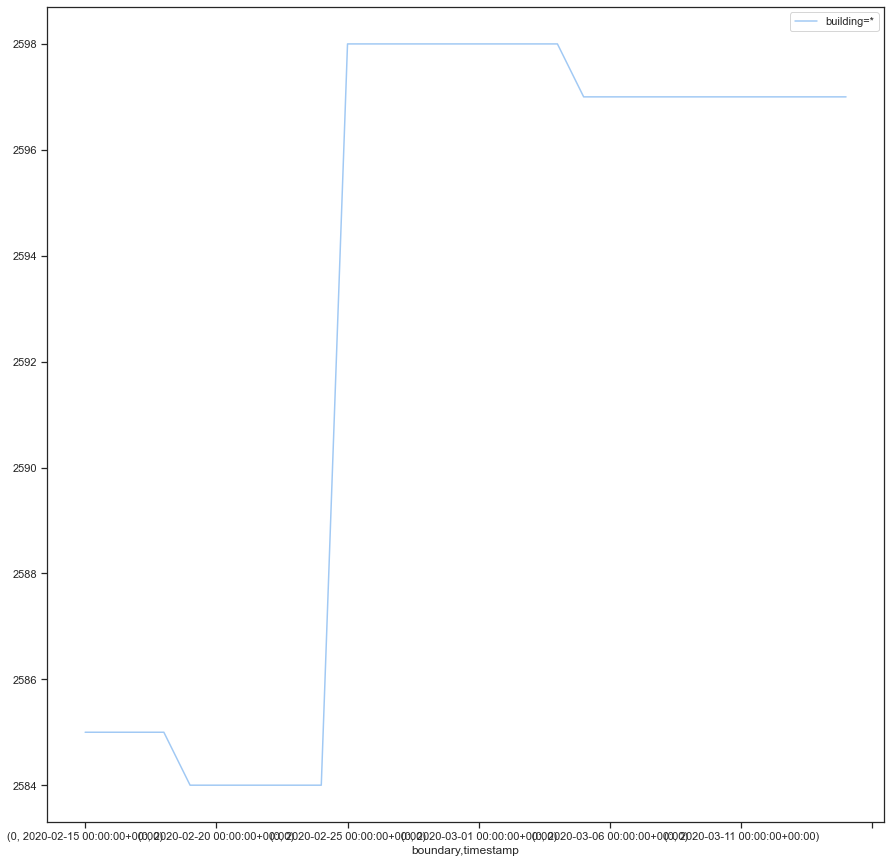

In [ ]:
buildings_vo.plot(figsize=(15,15))
plt.show()

In [ ]:
print("The total number of buildings BEFORE Vo' became a hotbed (2020-02-15) city is " + str(int(buildings_vo['building=*'].min())))
print("The total number of buildings AFTER Vo' became a hotbed (2020-02-15) city is " + str(int(buildings_vo['building=*'].max())))

The total number of buildings BEFORE Vo' became a hotbed (2020-02-15) city is 2584
The total number of buildings AFTER Vo' became a hotbed (2020-02-15) city is 2598


In [ ]:
# organize the data to crfeate a csv fle
buildings_vo.reset_index(inplace=True)
buildings_vo.rename(columns={'building=*':'total_building'}, inplace=True)
del buildings_vo['boundary']
buildings_vo.total_building = buildings_vo.total_building.astype(int)

In [ ]:
# save file
buildings_vo.to_csv("data" + os.sep + "buildings_vo.csv", index=False)

## data entry regarding pharmacies in Italy 

In [ ]:
%%time
pharmacy = client.elements.count.groupByBoundary.post(bpolys=borders_italy.geometry.to_json(), filter="amenity=pharmacy",time=time_weaks_2020)

In [ ]:
pharmacy_df = pharmacy.as_dataframe()

In [ ]:
pharmacy_df.head(10)

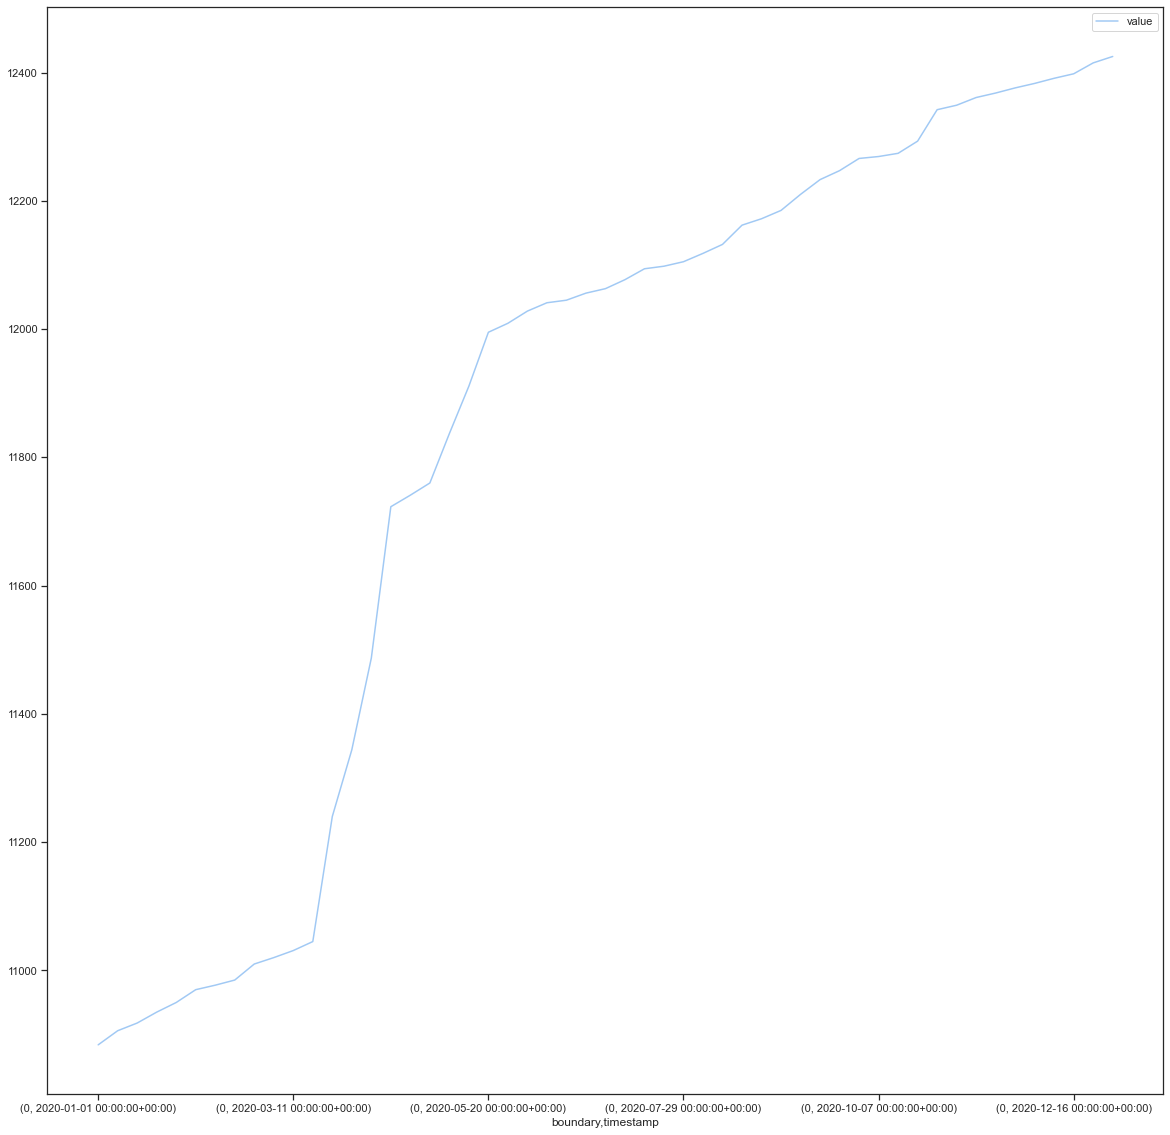

In [ ]:
pharmacy_df.plot(figsize=(20,20))
plt.show()

In [ ]:
pharmacy_df.reset_index(inplace=True)
pharmacy_df['value'] = pharmacy_df.value.astype(int)
pharmacy_df.rename(columns={"value":"pharmacies"}, inplace=True)

In [ ]:
# save the file
pharmacy_df.to_csv("data" + os.sep + "phamarcies_data_inserted_italy.csv",index=False)

## insertion of delivery service keys created during lock-down
all the tag like "*:covid19=*"


In [ ]:
tags = ["delivery:covid19=*","opening_hours:covid19=*", "description:covid19=*","takeaway:covid19=*","access:covid19=*"]

In [ ]:
%%time
data = []
for tag in tags:
    response = client.elements.count.groupByBoundary.post(
        bpolys=borders_italy.geometry.to_json(),
        time=time_weaks_2020,
        filter="{}".format(tag))
    data.append(response.as_dataframe().rename(columns={"value":tag}))
covid_delivery = pd.concat(data, axis=1)

CPU times: user 11.7 s, sys: 451 ms, total: 12.2 s
Wall time: 32min 26s


In [ ]:
covid_delivery.head(10)

delivery:covid19=*  \
boundary timestamp                                       
0        2020-01-01 00:00:00+00:00                 0.0   
         2020-01-08 00:00:00+00:00                 0.0   
         2020-01-15 00:00:00+00:00                 0.0   
         2020-01-22 00:00:00+00:00                 0.0   
         2020-01-29 00:00:00+00:00                 0.0   
         2020-02-05 00:00:00+00:00                 0.0   
         2020-02-12 00:00:00+00:00                 0.0   
         2020-02-19 00:00:00+00:00                 0.0   
         2020-02-26 00:00:00+00:00                 0.0   
         2020-03-04 00:00:00+00:00                 0.0   

                                    opening_hours:covid19=*  \
boundary timestamp                                            
0        2020-01-01 00:00:00+00:00                      0.0   
         2020-01-08 00:00:00+00:00                      0.0   
         2020-01-15 00:00:00+00:00                      0.0   
         2020-01-22 00:00:00+00:00                      0.0   
         2020-01-29 00:00:00+00:00                      0.0   
         2020-02-05 00:00:00+00:00                      0.0   
         2020-02-12 00:00:00+00:00                      0.0   
         2020-02-19 00:00:00+00:00                      0.0   
         2020-02-26 00:00:00+00:00                      0.0   
         2020-03-04 00:00:00+00:00                      0.0   

                                    description:covid19=*  takeaway:covid19=*  \
boundary timestamp                                                              
0        2020-01-01 00:00:00+00:00                    0.0                 0.0   
         2020-01-08 00:00:00+00:00                    0.0                 0.0   
         2020-01-15 00:00:00+00:00                    0.0                 0.0   
         2020-01-22 00:00:00+00:00                    0.0                 0.0   
         2020-01-29 00:00:00+00:00                    0.0                 0.0   
         2020-02-05 00:00:00+00:00                    0.0                 0.0   
         2020-02-12 00:00:00+00:00                    0.0                 0.0   
         2020-02-19 00:00:00+00:00                    0.0                 0.0   
         2020-02-26 00:00:00+00:00                    0.0                 0.0   
         2020-03-04 00:00:00+00:00                    0.0                 0.0   

                                    access:covid19=*  
boundary timestamp                                    
0        2020-01-01 00:00:00+00:00               0.0  
         2020-01-08 00:00:00+00:00               0.0  
         2020-01-15 00:00:00+00:00               0.0  
         2020-01-22 00:00:00+00:00               0.0  
         2020-01-29 00:00:00+00:00               0.0  
         2020-02-05 00:00:00+00:00               0.0  
         2020-02-12 00:00:00+00:00               0.0  
         2020-02-19 00:00:00+00:00               0.0  
         2020-02-26 00:00:00+00:00               0.0  
         2020-03-04 00:00:00+00:00               0.0

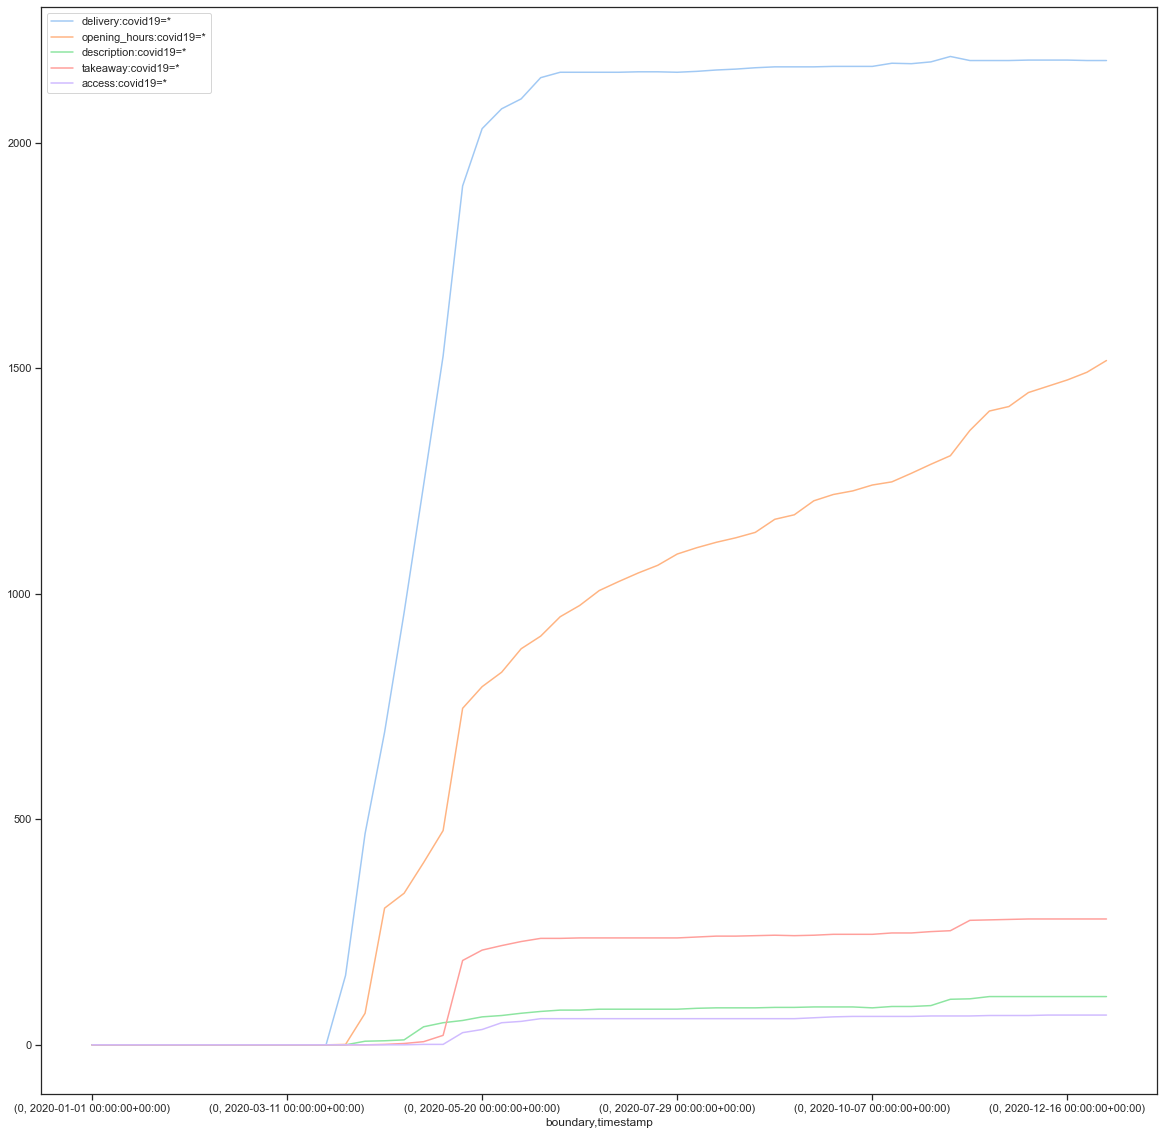

In [ ]:
covid_delivery.plot(figsize=(20,20))
plt.show()

In [ ]:
covid_delivery.reset_index(inplace=True)

In [ ]:
covid_delivery.rename(columns={
    "delivery:covid19=*":"delivery",
    "opening_hours:covid19=*":"opening_hours",
    "description:covid19=*":"description",
    "takeaway:covid19=*":"takeway",
    "access:covid19=*":"access"}, inplace=True)

In [ ]:
del covid_delivery['boundary']

In [ ]:
covid_delivery.delivery = covid_delivery.delivery.astype(int)
covid_delivery.opening_hours = covid_delivery.opening_hours.astype(int)
covid_delivery.description = covid_delivery.description.astype(int)
covid_delivery.takeway = covid_delivery.takeway.astype(int)
covid_delivery.access = covid_delivery.access.astype(int)

In [ ]:
# save the file
covid_delivery.to_csv("data" + os.sep + "covid_tags_delivery_services_italy.csv",index=False)